In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
np.random.seed(666)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier

from catboost import Pool, CatBoostClassifier, cv
import lightgbm as lgb

from scipy.stats import ks_2samp, chisquare, uniform

In [2]:
pd.set_option('display.max_columns', 200)

*Та же часть предобработки, которая есть в предыдущей работе. Можно пропустить*

In [3]:
train = pd.read_csv('application_train.csv')
print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
test = pd.read_csv('application_test.csv')
test.drop(columns='SK_ID_CURR', inplace=True)
print(test.shape)
test.head()

(48744, 120)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-186

In [5]:
y = train['TARGET']
train.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)

У нас несбалансированная выборка и это могло бы иметь проблемы, если итогвая метрика была не ROC AUC, или если бы мы применяли невероятностные алгоритмы, вроде SVM. А так ничего страшного и можно продолжать без увеличения редкого класса или уменьшения большого

In [6]:
y.value_counts(True) * 100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

Есть немало признаков, где половина - это пропуски.

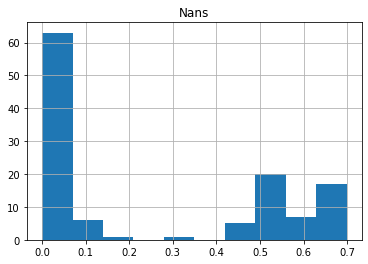

In [7]:
nans = pd.DataFrame(
    {
        'Nans': train.isna().sum() / train.shape[0],
        'Dtype': train.dtypes,
    }
).sort_values('Nans', ascending=False)
nans.hist();

Количество колонок с большим количеством пропусков

In [8]:
(nans['Nans'] > 0.4).sum() / nans.shape[0]

0.4083333333333333

Изначально была мысль удалить половину датасета, но так мы теряем много информации

In [9]:
# train.drop(columns=nans.loc[nans['Nans'] > 0.4].index, inplace=True)
# test.drop(columns=nans.loc[nans['Nans'] > 0.4].index, inplace=True)

Заполним пропуски средним

In [10]:
for column in train.columns:
    if train[column].dtype != np.dtype('object'):
        train[column] = train[column].fillna(train[column].mean())
    
    if test[column].dtype != np.dtype('object'):
        test[column] = test[column].fillna(test[column].mean())

Можно создать пару признаков на основе предметного знания

* CREDIT_INCOME_PERCENT - какую часть составляет кредит от зарплаты
* ANNUITY_INCOME_PERCENT - какую часть составляют выплаты от зарплаты
* CREDIT_TERM - какую часть составляют выплаты от зарплаты
* DAYS_EMPLOYED_PERCENT - какую часть составляет стаж от возраста

In [11]:
train.loc[:, 'CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train.loc[:, 'ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train.loc[:, 'CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train.loc[:, 'DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

test.loc[:, 'CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test.loc[:, 'ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test.loc[:, 'CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
test.loc[:, 'DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

In [12]:
cat_feats = train.columns[train.dtypes == np.dtype('object')]
train.fillna('nan', inplace=True)
test.fillna('nan', inplace=True)

In [13]:
cb_train = Pool(train, y, cat_features=cat_feats)
cb_test = Pool(test, cat_features=cat_feats)

Самописная cross_val_score функция

In [14]:
def cross_val(model, X, y):
    kf = KFold(3);
    scores = []
    
    for train_index, test_index in kf.split(X, y):
        train_X, train_y = X.loc[train_index], y.loc[train_index]
        test_X, test_y = X.loc[test_index], y.loc[test_index]
        
        model.fit(train_X, train_y)
        
        pred_y = model.predict_proba(test_X)[:, 1]
        score = roc_auc_score(test_y, pred_y)
        scores.append(score)
        
    scores = np.array(scores)
    print(f"mean: {scores.mean():.5f}, std: {scores.std():.5f}")
    return scores

# Все задания выполняются на датасете Home credit на kaggle

Для начала прогоним обычную модель на датасете, чтобы оставить только полезные признаки. Тут их слишком много, чтобы в дальнейшем делать кросс-валидации

In [15]:
model = CatBoostClassifier()

In [16]:
model.fit(cb_train, verbose=400)

Learning rate set to 0.118919
0:	learn: 0.5817136	total: 627ms	remaining: 10m 26s
400:	learn: 0.2330977	total: 3m 8s	remaining: 4m 41s
800:	learn: 0.2236203	total: 6m 7s	remaining: 1m 31s
999:	learn: 0.2198568	total: 7m 37s	remaining: 0us


Очень приятный результат

In [17]:
roc_auc_score(cb_train.get_label(), model.predict_proba(cb_train)[:, 1])

0.8235233432097455

In [18]:
feat_importance = model.get_feature_importance(prettified=True)

На глаз видно что только 20-40 признаков играют роль

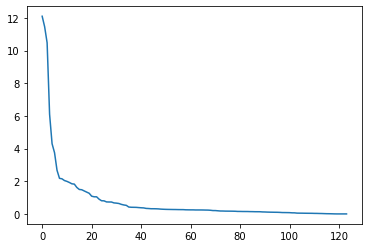

In [19]:
feat_importance['Importances'].plot()

In [20]:
important_columns = feat_importance['Feature Id'][:25]

In [21]:
cat_feats = pd.merge(pd.Series(important_columns, name='columns'), pd.Series(cat_feats, name='columns')).values.reshape(-1)

In [22]:
cb_train = Pool(train[important_columns], y, cat_features=cat_feats)
cb_test = Pool(test[important_columns], cat_features=cat_feats)

0. Взять три гиперпараметра для градиентного бустинга, и для каждого проварьировать один из них, фиксируя остальные.  Построить графики зависимости метрики на кросс-валидации от параметра.  Прокомментируйте, какие параметры и как влияют на переобучение. 

In [23]:
params = {
    'learning_rate': [0.05, 0.10, 0.15],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
}

# Переделанная часть

Stopped by overfitting detector  (10 iterations wait)
Stopped by overfitting detector  (10 iterations wait)
Stopped by overfitting detector  (10 iterations wait)


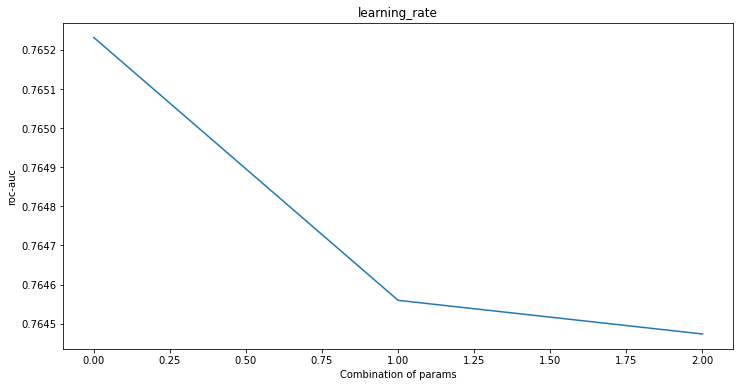

In [26]:
scores = []
for learning_rate in params['learning_rate']:
    cb_scorer = cv(
        cb_train, 
        params={
            'learning_rate': learning_rate,
            'eval_metric': 'AUC', 
            'loss_function': 'Logloss'
        }, nfold=5, iterations=1000, verbose=False, early_stopping_rounds=10)

    scores.append(cb_scorer['test-AUC-mean'].iloc[-1])
    
plt.figure(figsize=(12, 6))
plt.xlabel('Combination of params')
plt.ylabel('roc-auc')
plt.title('learning_rate')
plt.plot(scores);

Stopped by overfitting detector  (10 iterations wait)


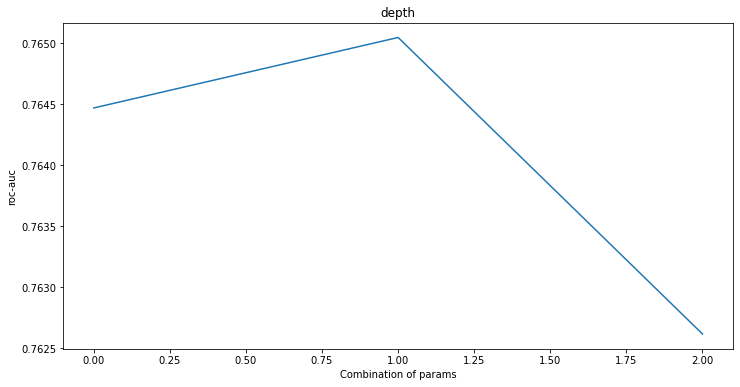

In [27]:
scores = []
for depth in params['depth']:
    cb_scorer = cv(
        cb_train, 
        params={
            'depth': depth,
            'eval_metric': 'AUC', 
            'loss_function': 'Logloss'
        }, nfold=5, iterations=1000, verbose=False, early_stopping_rounds=10)

    scores.append(cb_scorer['test-AUC-mean'].iloc[-1])
    
plt.figure(figsize=(12, 6))
plt.xlabel('Combination of params')
plt.ylabel('roc-auc')
plt.title('depth')
plt.plot(scores);

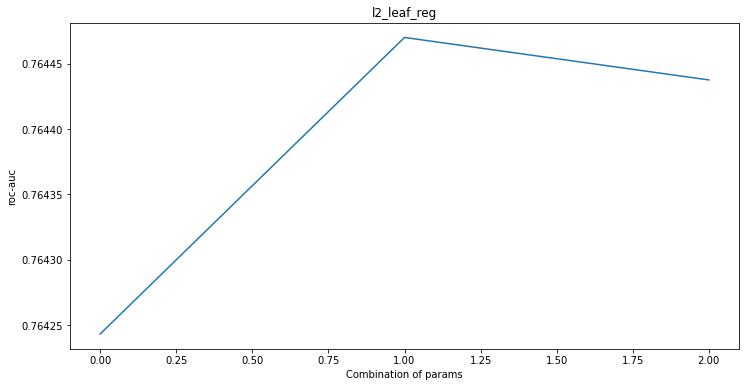

In [28]:
scores = []
for l2_leaf_reg in params['l2_leaf_reg']:
    cb_scorer = cv(
        cb_train, 
        params={
            'l2_leaf_reg': l2_leaf_reg,
            'eval_metric': 'AUC', 
            'loss_function': 'Logloss'
        }, nfold=5, iterations=1000, verbose=False, early_stopping_rounds=10)

    scores.append(cb_scorer['test-AUC-mean'].iloc[-1])
    
plt.figure(figsize=(12, 6))
plt.xlabel('Combination of params')
plt.ylabel('roc-auc')
plt.title('l2_leaf_reg')
plt.plot(scores);

По графикам, можно судить, что depth и l2_leaf_reg мы определили посередине и можно возле его окрестностей потестить или так оставить, а вот с learning_rate надо делать меньше

1. Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров.

In [90]:
params = {
    'learning_rate': [0.15, 0.20, 0.25, 0.30, 0.50, 0.75, 1],
    'depth': [8, 10, 12],
    'l2_leaf_reg': [3, 5, 7, 9, 12],
}

In [91]:
model = CatBoostClassifier()

In [ ]:
model.randomized_search(params, cb_train, plot=True, verbose=False, cv=4)

Случайный поиск повел себя не так продуктивно, как мне хотелось бы. Так проверим дополнительно две итерации

In [97]:
cb_scorer = cv(
    cb_train, 
    params={
        'learning_rate': 0.15,
        'depth': 8,
        'l2_leaf_reg': 3,
        'eval_metric': 'AUC', 
        'loss_function': 'Logloss'
    }, nfold=4, verbose=False, early_stopping_rounds=10
)

Stopped by overfitting detector  (10 iterations wait)


С самыми лучшими подобранными параметрами roc auc равен 0.76. Заметно лучше по сравнении с обычными параметрами

In [98]:
cb_scorer

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.671792,0.016235,0.545043,0.001905,0.544944,0.001969
1,1,0.702392,0.007582,0.448152,0.002810,0.448032,0.002825
2,2,0.710185,0.006656,0.386313,0.001729,0.386094,0.001880
3,3,0.714658,0.007997,0.345177,0.001466,0.344863,0.001509
4,4,0.720918,0.006567,0.318364,0.002101,0.318141,0.002237
...,...,...,...,...,...,...,...
164,164,0.761276,0.003195,0.245440,0.000789,0.228539,0.000665
165,165,0.761341,0.003189,0.245415,0.000784,0.228423,0.000680
166,166,0.761335,0.003134,0.245416,0.000771,0.228340,0.000717
167,167,0.761303,0.003073,0.245428,0.000749,0.228221,0.000740


In [99]:
cb_scorer = cv(
    cb_train, 
    params={
        'learning_rate': 0.75,
        'depth': 10,
        'l2_leaf_reg': 5,
        'eval_metric': 'AUC', 
        'loss_function': 'Logloss'
    }, nfold=4, verbose=False, early_stopping_rounds=10
)

Stopped by overfitting detector  (10 iterations wait)


Здесь мы просто удостоверились в самом худшем результате, но зато с низким трейн скором

In [101]:
cb_scorer.tail(3)

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
18,18,0.735698,0.003704,0.254913,0.001021,0.229101,0.001264
19,19,0.735386,0.004288,0.255161,0.001264,0.227928,0.001410
20,20,0.734785,0.003966,0.255495,0.001221,0.226809,0.001508


Запустим grid search по интересному нам интервалу

In [106]:
params = {
    'learning_rate': [0.10, 0.15],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 2, 3],
}

In [ ]:
%%time
model = CatBoostClassifier()
gs_res = model.grid_search(params, cb_train, plot=True, verbose=False, cv=4)

С настроенной моделью скор заметно улучшился. Теперь 0,78

In [113]:
roc_auc_score(cb_train.get_label(), model.predict_proba(cb_train)[:, 1])

0.7877048972573907

2. Построить график feature importance. Какие признаки оказались самыми важными? 

На самом деле мы до этого уже и так оставили только нужные признаки, но в плане важности, здесь почти тоже самое, что и с RandomForest. EXT_SOURCE, CREDIT_TERM, DAYS_BIRTH - так же находятся в топе

In [115]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,EXT_SOURCE_3,19.027336
1,EXT_SOURCE_2,16.415977
2,CREDIT_TERM,14.981472
3,EXT_SOURCE_1,8.345450
4,DAYS_BIRTH,5.433852
5,AMT_GOODS_PRICE,4.464132
6,NAME_EDUCATION_TYPE,2.703333
7,AMT_ANNUITY,2.656079
8,CODE_GENDER,2.526642
9,OWN_CAR_AGE,2.248350


Для интереса - загрузим предсказания на тестовой выборке

In [121]:
pred_df = pd.read_csv("sample_submission.csv")
pred_df['TARGET'] = model.predict_proba(cb_test)[:, 1]
pred_df.to_csv("submission.csv", index=False)

private: 0.75878

Теперь переходим к стекингу
Используем реализацию https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html 

До этого я обучал катбуст на Pool и, к сожалению, в sklearn и катбусте не предусмотрена возможность совмещать. Так что снова преобразуем датасет

Во первых оставим только пол и образование, как категориальные признаки

In [128]:
feat_importance[feat_importance['Feature Id'].isin(cat_feats)]

,Feature Id,Importances
11,CODE_GENDER,1.923948
14,NAME_EDUCATION_TYPE,1.621977
17,ORGANIZATION_TYPE,1.405733
20,OCCUPATION_TYPE,1.085530
24,NAME_FAMILY_STATUS,0.805854


In [130]:
train = train[important_columns]
test = test[important_columns]

In [131]:
train.drop(columns=['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS'], inplace=True)
test.drop(columns=['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS'], inplace=True)

In [133]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

1. Построить стекинг для 5 различных моделей по вашему выбору с разными параметрами. Можете взять любые, например 2 бустинга, 2 случайных леса, лог рег. Записать скор на тестовой выборке.

Возьмем случайные леса из предыдущего задания, а именно лучшую gridsearch и лучшую randomizedsearch

In [138]:
rf_gs = RandomForestClassifier(**{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2})

In [140]:
rf_rs = RandomForestClassifier(**{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5})

И тоже самое с бустингом

In [151]:
ct_gs = CatBoostClassifier(depth=4, l2_leaf_reg=2, learning_rate=0.1, early_stopping_rounds=5, loss_function='Logloss', verbose=False)

In [153]:
ct_rs = CatBoostClassifier(depth=8, l2_leaf_reg=3, learning_rate=0.15, early_stopping_rounds=5, loss_function='Logloss', verbose=False)

In [154]:
estimators = [
    ('RandomForest_1', rf_gs),
    ('RandomForest_2', rf_rs),
    ('CatBoost_1', ct_gs),
    ('CatBoost_2', ct_rs),
]

In [155]:
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

Довольно таки мало, на самом деле

In [156]:
%time scores = cross_val(stacking, train, y)

mean: 0.75984, std: 0.00288
Wall time: 34min 23s


In [163]:
test['CODE_GENDER_XNA'] = 0

In [166]:
pred_df = pd.read_csv("sample_submission.csv")
pred_df['TARGET'] = stacking.predict_proba(test)[:, 1]
pred_df.to_csv("submission.csv", index=False)

private: 0.74584

Я немного удивлен, что стэкинг дал более слабый результат, чем отдельно обученный Catboost. Хотя там был Catboost с Pool и может это эффективная обработка категорий так помог

2. Теперь уберем из ансамбля наилучшую модель и снова постройте стекинг. Как изменился результат? Прокомментируйте. 

In [167]:
estimators = [
    ('RandomForest_1', rf_gs),
    ('RandomForest_2', rf_rs),
    ('CatBoost_2', ct_rs),
]

In [168]:
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [169]:
%time scores = cross_val(stacking, train, y)

mean: 0.74896, std: 0.00250
Wall time: 26min 26s


In [170]:
pred_df = pd.read_csv("sample_submission.csv")
pred_df['TARGET'] = stacking.predict_proba(test)[:, 1]
pred_df.to_csv("submission.csv", index=False)

private: 0.73078

Результат конечно упал. Причем заметно сильно. В целом, возможно у меня получилось неудачно, но хорошо оттюненный бустинг показывает отличные результаты сам по себе.

Еще складывается впечатление, что если нет возможности загружать Pool в StackingClassifer, то возможно лучше самому писать свой собственный стэкинг, так как такой удобный инструмент дает хорошие результаты